In [44]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata as ad
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

ImportError: cannot import name 'cosine_similarity' from 'sklearn' (/Users/mo2016/Library/Caches/pypoetry/virtualenvs/scc-helical--RZZoshj-py3.11/lib/python3.11/site-packages/sklearn/__init__.py)

# Load embeddings and create new annData

In [45]:
embeddings = np.load("../output/embeddings/KC_tumor_TSKknockdown_embeddings_264_noise1.npy")
scc_annData = sc.read_h5ad(f"../output/perturbed_noise_datasets/KC_tumor_TSKknockdown_annData_264_noise1.h5ad")
scc_embeddings_annData = ad.AnnData(X=embeddings, obs=scc_annData.obs, var=None)
scc_embeddings_annData

/Users/mo2016/Library/Caches/pypoetry/virtualenvs/scc-helical--RZZoshj-py3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/mo2016/Library/Caches/pypoetry/virtualenvs/scc-helical--RZZoshj-py3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 264 × 512
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient', 'tum.norm', 'level1_celltype', 'level2_celltype', 'level3_celltype'

# Visualize using UMAP

Visualize embeddings of TSKs with and without perturbations as well as healthy keratinocytes


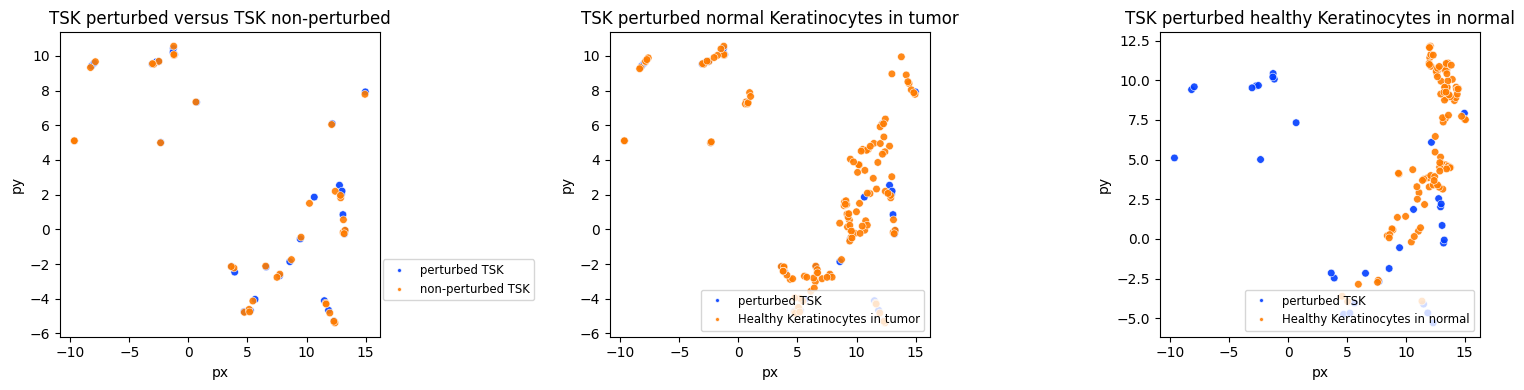

In [33]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(embeddings)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])




labels1 = scc_annData.obs['tum.norm']
plot_df['tum.norm'] = labels1.values

labels2 = scc_annData.obs['level3_celltype']
plot_df['level3_celltype'] = labels2.values


TSK_perturbed = plot_df[(plot_df['level3_celltype'] == 'TSK') & (plot_df['tum.norm'] == 'Tumor_knockdown')]
TSK_nonperturbed = plot_df[(plot_df['level3_celltype'] == 'TSK') & (plot_df['tum.norm'] == 'Tumor')]
TSKperturbed_nonperturbed = pd.concat([TSK_perturbed, TSK_nonperturbed])

Tumor =  plot_df[plot_df['tum.norm'] == 'Tumor']
TSK_versus_tumor = pd.concat([TSK_perturbed, Tumor])

Normal =  plot_df[plot_df['tum.norm'] == 'Normal']
TSK_versus_normal = pd.concat([TSK_perturbed, Normal])


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

label_mapping = {'Tumor': 'non-perturbed TSK', 'Tumor_knockdown': 'perturbed TSK'}
TSKperturbed_nonperturbed['new_labels'] = TSKperturbed_nonperturbed['tum.norm'].map(label_mapping)
sns.scatterplot(data=TSKperturbed_nonperturbed, x='px', y='py', hue='new_labels', palette="bright", s=30, ax=axs[0], alpha=0.9)
axs[0].set_title('TSK perturbed versus TSK non-perturbed')

label_mapping = {'Tumor': 'Healthy Keratinocytes in tumor', 'Tumor_knockdown': 'perturbed TSK'}
TSK_versus_tumor['new_labels'] = TSK_versus_tumor['tum.norm'].map(label_mapping)
sns.scatterplot(data=TSK_versus_tumor, x='px', y='py', hue='new_labels', palette="bright",s=30, ax=axs[1], alpha=0.9)
axs[1].set_title('TSK perturbed normal Keratinocytes in tumor')
# 
label_mapping = {'Normal': 'Healthy Keratinocytes in normal', 'Tumor_knockdown': 'perturbed TSK'}
TSK_versus_normal['new_labels'] = TSK_versus_normal['tum.norm'].map(label_mapping)
sns.scatterplot(data=TSK_versus_normal, x='px', y='py', hue='new_labels',palette="bright", s=30, ax=axs[2], alpha=0.9)
axs[2].set_title('TSK perturbed healthy Keratinocytes in normal')





# Adjust legend size and position
legend = axs[1].legend(loc='lower right', fontsize='small', title_fontsize='small', markerscale=0.5, frameon=True)
legend = axs[2].legend(loc='lower right', fontsize='small', title_fontsize='small', markerscale=0.5, frameon=True)
legend = axs[0].legend(loc='lower right', fontsize='small', title_fontsize='small', markerscale=0.5, frameon=True)
legend.set_bbox_to_anchor((1.5, 0.1))  # Fine-tune placement if needed
plt.tight_layout()
plt.show()


Perturbations on TSK genes do not seem to significantly shift TSK embeddings (plot1). \
No significant shift seen towards healthy keratinocytes when perturbing TSKs with perturbations -->ITGB1':'deletion', 'FERMT1':'deletion', 'CD151':'deletion', 'ARPC2':'deletion', 'HSP90B1':'deletion

In [60]:
def cosine_similarity_whole_dataset(dataset1, dataset2):
    # Step 1: Compute centroids
    centroid1 = np.mean(dataset1.X, axis=0)
    centroid2 = np.mean(dataset2.X, axis=0)
    
    # Step 2: Compute cosine similarity between centroids
    centroid_similarity = cosine_similarity([centroid1], [centroid2])
    return centroid_similarity

In [61]:

TSK_perturbed = scc_embeddings_annData[(scc_embeddings_annData.obs['tum.norm'] == 'Tumor_knockdown')]
TSK_nonperturbed = scc_embeddings_annData[(scc_embeddings_annData.obs['tum.norm'] == 'Tumor') & (scc_embeddings_annData.obs['level3_celltype'] == 'TSK')]
normal_healthy_keratinocytes = scc_embeddings_annData[scc_embeddings_annData.obs['tum.norm'] == 'Normal']
tumor_healthy_keratinocytes = scc_embeddings_annData[scc_embeddings_annData.obs['tum.norm'] == 'Tumor']


print('TSK_perturbed, TSK_nonperturbed:',cosine_similarity_whole_dataset(TSK_perturbed, TSK_nonperturbed))

print( '')

print('TSK_perturbed, normal_healthy_keratinocytes:',cosine_similarity_whole_dataset(TSK_perturbed, normal_healthy_keratinocytes))
print('TSK_perturbed, tumor_healthy_keratinocytes:',cosine_similarity_whole_dataset(TSK_perturbed, tumor_healthy_keratinocytes))

print( '')

print('TSK_nonperturbed, normal_healthy_keratinocytes:',cosine_similarity_whole_dataset(TSK_nonperturbed, normal_healthy_keratinocytes))
print('TSK_nonperturbed, tumor_healthy_keratinocytes:',cosine_similarity_whole_dataset(TSK_nonperturbed, tumor_healthy_keratinocytes))

TSK_perturbed, TSK_nonperturbed: [[0.99995756]]

TSK_perturbed, normal_healthy_keratinocytes: [[0.99586874]]
TSK_perturbed, tumor_healthy_keratinocytes: [[0.9996728]]

TSK_nonperturbed, normal_healthy_keratinocytes: [[0.996125]]
TSK_nonperturbed, tumor_healthy_keratinocytes: [[0.9997896]]


In [61]:
def cosine_similarity_parwise(dataset1, dataset2):
        
    pairwise_similarities = cosine_similarity(dataset1.X, dataset2.X)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pairwise_similarities, cmap="coolwarm", cbar=True)
    plt.title("Pairwise Cosine Similarities")
    plt.xlabel("Normal Cells")
    plt.ylabel("Perturbed Cells")
    plt.show()

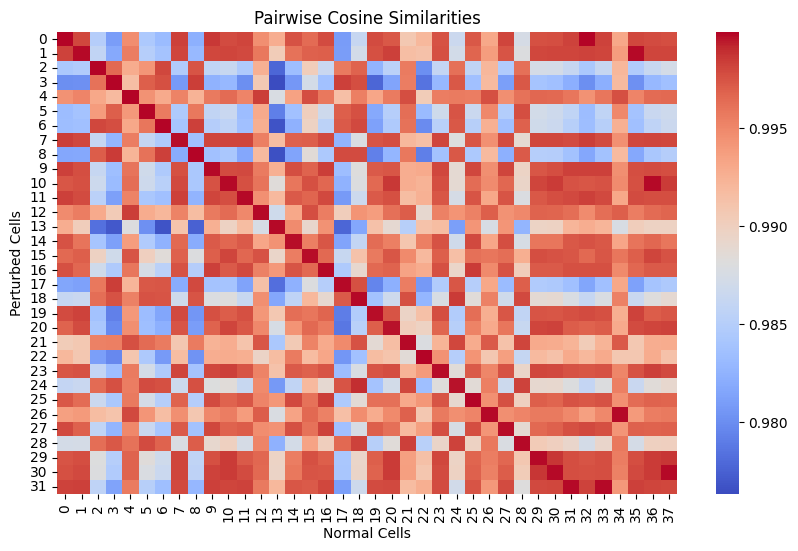

In [62]:
cosine_similarity_parwise(TSK_perturbed, TSK_nonperturbed)

In [64]:
TSK_perturbed.obs

,nCount_RNA,nFeature_RNA,patient,tum.norm,level1_celltype,level2_celltype,level3_celltype
P2_Tumor_AATCCAGAGATGCCAG,17935,3818,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_ACGATGTAGTGAAGTT,24497,4219,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_AGTGTCACATCACGAT,59627,6481,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_ATGGGAGGTATGAAAC,42718,5793,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_CAACCTCAGTTAGCGG,34315,5174,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_CACACTCAGAAACGAG,35115,5767,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_CACCACTCAAGCCTAT,62185,6310,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_CCTCAGTTCTGTTTGT,22723,4138,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_CGAACATAGCAGGTCA,46794,5991,P2,Tumor_knockdown,Epithelial,TSK,TSK
P2_Tumor_CGACTTCAGAGCAATT,19082,3954,P2,Tumor_knockdown,Epithelial,TSK,TSK
